In [1]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [4]:
from os import listdir
from os.path import isfile, join
import glob

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [6]:
mypath = '/home/chenming/ncrna/ncRDeep2/Data_Processing/EIIP_data/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [35]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/EIIP_data/T*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep2/Data_Processing/EIIP_data/Test_0.h5',
 '/home/chenming/ncrna/ncRDeep2/Data_Processing/EIIP_data/Test_1.h5']

In [8]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[10+fold_no],'r')
    hf_Test = h5.File(my_files8[fold_no],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [40]:
my_files8[20]
hf_val = h5.File(my_files8[20],'r')
X_val = hf_val['Train_Data']     # Get test set
X_val = np.array(X_val)
Y_val = hf_val['Label']       # Get test label
Y_val = np.array(Y_val)
Y_val = np_utils.to_categorical(Y_val, 13)    #  Process the label of test
X_val[:,:,0:4].shape

(2600, 750, 4)

In [42]:
X_val[0,0,:]

array([0.    , 1.    , 0.    , 0.    , 0.0806])

In [9]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

In [10]:
#class_names = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [11]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 5))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    x2=Flatten()(x)

    x3=Dense(128,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(32,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=inputs1, outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [12]:
X_train, Y_train, X_test, Y_test = get_file8(0)


In [13]:
model = model_conv(512, 20, 128, 5)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 750, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 731, 512)          51712     
_________________________________________________________________
batch_normalization_1 (Batch (None, 731, 512)          2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 731, 512)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 731, 512)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 365, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 361, 128)          327808    
__________

In [14]:

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 10s 2ms/step - loss: 2.1266 - acc: 0.2989 - val_loss: 1.7334 - val_acc: 0.4968
Epoch 2/500
5688/5688 [==============================] - 5s 895us/step - loss: 1.6488 - acc: 0.5077 - val_loss: 1.4903 - val_acc: 0.6345
Epoch 3/500
5688/5688 [==============================] - 5s 892us/step - loss: 1.4547 - acc: 0.5740 - val_loss: 1.3789 - val_acc: 0.6646
Epoch 4/500
5688/5688 [==============================] - 5s 870us/step - loss: 1.3278 - acc: 0.6414 - val_loss: 1.2598 - val_acc: 0.6946
Epoch 5/500
5688/5688 [==============================] - 5s 871us/step - loss: 1.2142 - acc: 0.6788 - val_loss: 1.1771 - val_acc: 0.7278
Epoch 6/500
5688/5688 [==============================] - 5s 875us/step - loss: 1.1188 - acc: 0.7126 - val_loss: 1.1282 - val_acc: 0.7278
Epoch 7/500
5688/5688 [==============================] - 5s 873us/step - loss: 1.0310 - acc: 0.7407 - val_loss: 1.0224 - val_acc: 0.

In [11]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 1))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    xx=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)

    xx=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)
    
    x2=keras.layers.concatenate([xx,x],axis=1)
    
    x2=Conv1D(filters=32,kernel_size=2,strides=2,kernel_initializer=initializers.random_uniform()) (x2)
    x2 = BatchNormalization()(x2)
    x2=Dropout(0.2)(x2)
    x2=Activation('relu')(x2)
    x2=MaxPooling1D(pool_size=2, strides=2)(x2)
    
    x2=Flatten()(x2)

    x3=Dense(256,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(64,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=[inputs1,inputs2], outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [12]:
model = model_conv(512, 20, 128, 6)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 750, 1)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 750, 4)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 731, 512)     10752       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 731, 512)     41472       input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [15]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    EIIP_train = X_train[:,:,4].reshape((5688,750,1))
    EIIP_test = X_test[:,:,4].reshape((632,750,1))
    model = model_conv(512, 20, 128, 6)
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],EIIP_train], Y_train, validation_data=([X_test[:,:,0:4],EIIP_test], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test[:,:,0:4],EIIP_test])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.8718354430379747, 0.8684615384615385, 0.877566615774163, 0.8711131144015395, 0.8613825134140778)
(0.8813291139240507, 0.8776923076923079, 0.8793484760524662, 0.8763651695682996, 0.8717258423372284)
(0.8908227848101266, 0.8903846153846153, 0.8920431214459553, 0.8904575451388214, 0.8817674987552615)
(0.865506329113924, 0.8597115384615385, 0.8713141940249393, 0.8628896746484762, 0.8545413479811949)
(0.8670886075949367, 0.8586538461538461, 0.8822189925545934, 0.8641970866868502, 0.8566825945973874)
(0.8971518987341772, 0.8922115384615386, 0.8966164835852843, 0.8936297280507012, 0.8885999053875647)
(0.8781645569620253, 0.8720192307692307, 0.8850538696659336, 0.8755283804045024, 0.8681979468719464)
(0.8607594936708861, 0.8559615384615384, 0.8752376023104543, 0.8601196161981683, 0.8500613821301719)
(0.8813291139240507, 0.8785576923076923, 0.8955063231837062, 0.8821468486221093, 0.8724910565502515)
(0.8813291139240507, 0.8750961538461539, 0.8856886472699469, 0.8777048988888578, 0.8716499914

In [16]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.8775316455696203
0.872875
0.8840594325867442
0.8754152062608325
0.8677100079446152


In [33]:
EIIP_train = X_train[:,:,4].reshape((5688,750,1))
EIIP_test = X_test[:,:,4].reshape((632,750,1))

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train[:,:,0:4],EIIP_train], Y_train, validation_data=([X_test[:,:,0:4],EIIP_test], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test[:,:,0:4],EIIP_test])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 13s 2ms/step - loss: 2.4287 - acc: 0.2289 - val_loss: 1.9406 - val_acc: 0.4051
Epoch 2/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.9461 - acc: 0.3820 - val_loss: 1.7659 - val_acc: 0.4699
Epoch 3/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.7107 - acc: 0.4587 - val_loss: 1.6013 - val_acc: 0.5443
Epoch 4/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.5585 - acc: 0.5125 - val_loss: 1.4876 - val_acc: 0.5886
Epoch 5/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.4205 - acc: 0.5603 - val_loss: 1.3754 - val_acc: 0.6123
Epoch 6/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.3230 - acc: 0.5923 - val_loss: 1.3124 - val_acc: 0.6408
Epoch 7/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.2363 - acc: 0.6250 - val_loss: 1.2444 - val_acc: 0.6614
Epoch 8

Epoch 61/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0996 - acc: 0.9717 - val_loss: 0.4985 - val_acc: 0.8592
Epoch 62/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0848 - acc: 0.9793 - val_loss: 0.4805 - val_acc: 0.8592
Epoch 63/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0879 - acc: 0.9756 - val_loss: 0.4714 - val_acc: 0.8623
Epoch 64/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0847 - acc: 0.9782 - val_loss: 0.4991 - val_acc: 0.8528
Epoch 65/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0799 - acc: 0.9800 - val_loss: 0.5151 - val_acc: 0.8481
Epoch 66/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0785 - acc: 0.9786 - val_loss: 0.4829 - val_acc: 0.8513
Epoch 67/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0761 - acc: 0.9808 - val_loss: 0.4212 - val_acc: 0.8813
Epoch 68/500
5688/5688 [========================

In [37]:
base = 'ACGT'

In [38]:
EIIP_dict = {
        'A': 0.1260,
        'C': 0.1340,
        'G': 0.0806,
        'T': 0.1335,
    }

In [39]:
trincleotides = [nn1 + nn2 + nn3 for nn1 in base for nn2 in base for nn3 in base]

In [40]:
EIIPxyz = {}
EIIPnum = []
i=0
for triN in trincleotides:
    EIIPxyz[triN] = EIIP_dict[triN[0]] + EIIP_dict[triN[1]] + EIIP_dict[triN[2]]
    EIIPnum.append(EIIP_dict[triN[0]] + EIIP_dict[triN[1]] + EIIP_dict[triN[2]])
    i=i+1

In [41]:
tnc_train = '/home/chenming/ncrna/ncRDeep2/Data_Processing/TNC/train_0.txt'
tnc_test = '/home/chenming/ncrna/ncRDeep2/Data_Processing/TNC/test_0.txt'

In [42]:
from numpy import loadtxt
tnc_test_lines = loadtxt(tnc_test, delimiter="\t", unpack=False)
tnc_train_lines = loadtxt(tnc_train, delimiter="\t", unpack=False)

In [43]:
tnc_test_lines = np.delete(tnc_test_lines, 0, 1)
tnc_train_lines = np.delete(tnc_train_lines, 0, 1)

In [44]:
tnc_train_lines.shape

(5688, 64)

In [45]:
tnc_train_lines[0]

array([0.00591716, 0.03550296, 0.01775148, 0.03550296, 0.01183432,
       0.01183432, 0.0295858 , 0.00591716, 0.02366864, 0.01183432,
       0.00591716, 0.01183432, 0.00591716, 0.0295858 , 0.02366864,
       0.01775148, 0.01775148, 0.01775148, 0.02366864, 0.01775148,
       0.        , 0.01775148, 0.01183432, 0.01183432, 0.0295858 ,
       0.0295858 , 0.00591716, 0.01183432, 0.        , 0.01775148,
       0.        , 0.0295858 , 0.0591716 , 0.        , 0.01183432,
       0.02366864, 0.04733728, 0.00591716, 0.01775148, 0.00591716,
       0.00591716, 0.01775148, 0.01183432, 0.        , 0.00591716,
       0.00591716, 0.01775148, 0.00591716, 0.00591716, 0.00591716,
       0.        , 0.        , 0.01775148, 0.00591716, 0.02366864,
       0.02366864, 0.03550296, 0.01775148, 0.01183432, 0.01183432,
       0.        , 0.01775148, 0.03550296, 0.01775148])

In [46]:
EIIPnum = np.asarray(EIIPnum)
EIIPnum

array([0.378 , 0.386 , 0.3326, 0.3855, 0.386 , 0.394 , 0.3406, 0.3935,
       0.3326, 0.3406, 0.2872, 0.3401, 0.3855, 0.3935, 0.3401, 0.393 ,
       0.386 , 0.394 , 0.3406, 0.3935, 0.394 , 0.402 , 0.3486, 0.4015,
       0.3406, 0.3486, 0.2952, 0.3481, 0.3935, 0.4015, 0.3481, 0.401 ,
       0.3326, 0.3406, 0.2872, 0.3401, 0.3406, 0.3486, 0.2952, 0.3481,
       0.2872, 0.2952, 0.2418, 0.2947, 0.3401, 0.3481, 0.2947, 0.3476,
       0.3855, 0.3935, 0.3401, 0.393 , 0.3935, 0.4015, 0.3481, 0.401 ,
       0.3401, 0.3481, 0.2947, 0.3476, 0.393 , 0.401 , 0.3476, 0.4005])

In [47]:
PseEIIP_test = []
for i in range(len(tnc_test_lines)):
    PseEIIP_test.append(np.multiply(tnc_train_lines[i],EIIPnum))

In [48]:
PseEIIP_test = np.asarray(PseEIIP_test)

In [49]:
PseEIIP_test.shape

(632, 64)

In [50]:
PseEIIP_train = []
for i in range(len(tnc_train_lines)):
    PseEIIP_train.append(np.multiply(tnc_train_lines[i],EIIPnum))

In [51]:
PseEIIP_train = np.asarray(PseEIIP_train)

In [52]:
PseEIIP_train.shape

(5688, 64)

In [53]:
PseEIIP_test = PseEIIP_test.reshape(632,64,1)
PseEIIP_train = PseEIIP_train.reshape(5688,64,1)

In [54]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 5))
    inputs2 = Input(shape=(64,1))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    xx=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)

    xx=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)
    
    x2=keras.layers.concatenate([xx,x],axis=1)
    
    x2=Conv1D(filters=64,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (x2)
    x2 = BatchNormalization()(x2)
    x2=Dropout(0.2)(x2)
    x2=Activation('relu')(x2)
    x2=MaxPooling1D(pool_size=2, strides=2)(x2)
    
    x2=Flatten()(x2)
    #xx=Flatten()(inputs2)
    
    #x2=keras.layers.concatenate([x2,xx],axis=-1)

    x3=Dense(128,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)
    
    

    x3=Dense(32,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=[inputs1,inputs2], outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [55]:
model = model_conv(512, 20, 128, 6)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 64, 1)        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 750, 5)       0                                            
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 45, 512)      10752       input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 731, 512)     51712       input_17[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [56]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,PseEIIP_train], Y_train, validation_data=([X_test,PseEIIP_test], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,PseEIIP_test])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 12s 2ms/step - loss: 2.3735 - acc: 0.2312 - val_loss: 1.9547 - val_acc: 0.3877
Epoch 2/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.9248 - acc: 0.3957 - val_loss: 1.8140 - val_acc: 0.5111
Epoch 3/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.7159 - acc: 0.4808 - val_loss: 1.6354 - val_acc: 0.5633
Epoch 4/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.5671 - acc: 0.5355 - val_loss: 1.5497 - val_acc: 0.6187
Epoch 5/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.4379 - acc: 0.5863 - val_loss: 1.4725 - val_acc: 0.6709
Epoch 6/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.3511 - acc: 0.6187 - val_loss: 1.3938 - val_acc: 0.6614
Epoch 7/500
5688/5688 [==============================] - 6s 1ms/step - loss: 1.2650 - acc: 0.6549 - val_loss: 1.3405 - val_acc: 0.6741
Epoch 8

Epoch 61/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0919 - acc: 0.9782 - val_loss: 0.3260 - val_acc: 0.8987
Epoch 62/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0871 - acc: 0.9824 - val_loss: 0.3548 - val_acc: 0.8924
Epoch 63/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0807 - acc: 0.9835 - val_loss: 0.4030 - val_acc: 0.8813
Epoch 64/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0807 - acc: 0.9838 - val_loss: 0.2741 - val_acc: 0.9209
Epoch 65/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0804 - acc: 0.9826 - val_loss: 0.3088 - val_acc: 0.8924
Epoch 66/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0785 - acc: 0.9831 - val_loss: 0.3059 - val_acc: 0.8987
Epoch 67/500
5688/5688 [==============================] - 6s 1ms/step - loss: 0.0807 - acc: 0.9833 - val_loss: 0.3692 - val_acc: 0.8924
Epoch 68/500
5688/5688 [========================

In [48]:
Y_test.shape

(632, 13)

In [49]:
y = model.predict([X_test,PseEIIP_test])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)

In [94]:
precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
classification_reports = classification_report(y_test_non_category, y_predict_non_category)
print(auc,recall,precision,fscore,mcc)

(0.8686708860759493, 0.8584615384615385, 0.9005817633171317, 0.8644950615536616, 0.859739932167994)


Confusion matrix, without normalization


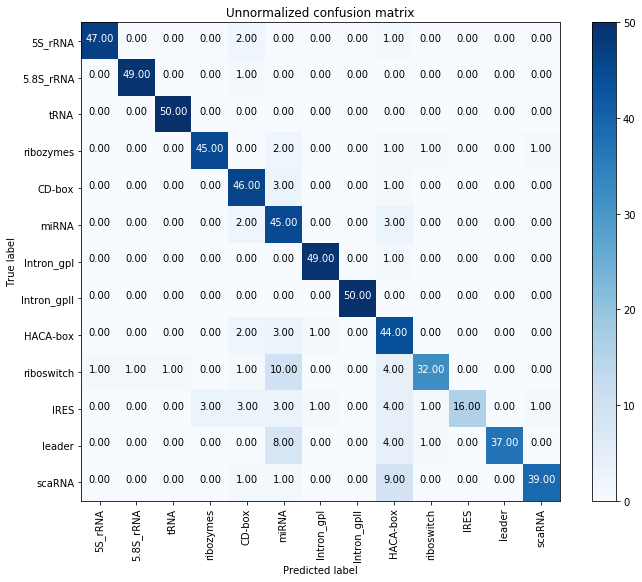

In [96]:
plot_confusion_matrix(conf_mat, classes=class_names, normalize=False,
                        title='Unnormalized confusion matrix')

In [19]:
def Conv1Dme(f, k, xo):
    x1o=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (xo)
    x1o = BatchNormalization()(x1o)
    x1o=Dropout(0.2)(x1o)
    x1o=Activation('relu')(x1o)
    #x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1o

In [20]:
def dense_block_1(xin, f, k):
    f1 = f
    k1 = k

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x1=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    return x1

In [21]:
def dense_block_2(xin, f, k):
    f1 = f
    k1 = k

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x12 = Concatenate(axis=-1)([x1,x11])
    x12 = Conv1Dme(f1, k1, x12)
    x13 = Concatenate(axis=-1)([x1,x11,x12])
    x14 = Conv1Dme(f1, k1, x13)
    x14=MaxPooling1D(pool_size=2, strides=2)(x14)
    
    return x14

In [82]:
def model_dense1(): # Model
    inputs1 = Input(shape=(750, 5))
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    ###############################################################
    #          1st dense block
    
    x1 = dense_block_2(x1, 128, 3)
    x1 = dense_block_2(x1, 256, 5)
    x1 = dense_block_2(x1, 512, 5)
    
       
    xf=Flatten()(x1)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=inputs1, outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [83]:
model = model_dense1()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 750, 5)       0                                            
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 750, 64)      1024        input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_130 (BatchN (None, 750, 64)      256         conv1d_109[0][0]                 
__________________________________________________________________________________________________
dropout_130 (Dropout)           (None, 750, 64)      0           batch_normalization_130[0][0]    
__________________________________________________________________________________________________
activation

In [84]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 29s 5ms/step - loss: 2.1351 - acc: 0.2885 - val_loss: 3.0787 - val_acc: 0.1250
Epoch 2/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.8445 - acc: 0.3922 - val_loss: 3.1558 - val_acc: 0.0807
Epoch 3/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.6047 - acc: 0.4866 - val_loss: 2.5739 - val_acc: 0.1408
Epoch 4/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.4185 - acc: 0.5621 - val_loss: 2.6189 - val_acc: 0.1250
Epoch 5/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.2490 - acc: 0.6183 - val_loss: 2.5512 - val_acc: 0.1741
Epoch 6/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.1313 - acc: 0.6535 - val_loss: 2.2317 - val_acc: 0.2848
Epoch 7/500
5688/5688 [==============================] - 14s 3ms/step - loss: 1.0189 - acc: 0.6885 - val_loss: 1.9653 - val_acc: 0.3813
E

In [85]:
for i in range(3):
    model = model_dense1()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict(X_test)
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9003164556962026
0.8987341772151899
0.9145569620253164


In [86]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 1))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    #x11 = Conv1Dme(128, 3, x1)
    #x11=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    #x12 = Conv1Dme(128, 5, x1)
    #x12=MaxPooling1D(pool_size=2, strides=2)(x12)
    
    #x1=keras.layers.concatenate([x11,x12],axis=-1)
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [88]:
EIIP_train = X_train[:,:,4].reshape((5688,750,1))
EIIP_test = X_test[:,:,4].reshape((632,750,1))

In [90]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],EIIP_train], Y_train, validation_data=([X_test[:,:,0:4],EIIP_test], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test[:,:,0:4],EIIP_test])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.8829113924050633
0.9145569620253164
0.9018987341772152


In [22]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 1))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    #x11 = Conv1Dme(128, 3, x1)
    #x11=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    #x12 = Conv1Dme(128, 5, x1)
    #x12=MaxPooling1D(pool_size=2, strides=2)(x12)
    
    #x1=keras.layers.concatenate([x11,x12],axis=-1)
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
    xxx = dense_block_1(xxx, 256, 4)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [93]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],EIIP_train], Y_train, validation_data=([X_test[:,:,0:4],EIIP_test], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test[:,:,0:4],EIIP_test])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9098101265822784
0.9193037974683544
0.8686708860759493


In [43]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
EIIP_val = X_val[:,:,4].reshape((2600,750,1))
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    EIIP_train = X_train[:,:,4].reshape((5688,750,1))
    EIIP_test = X_test[:,:,4].reshape((632,750,1))
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],EIIP_train], Y_train, validation_data=([X_test[:,:,0:4],EIIP_test], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_val[:,:,0:4],EIIP_val])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.915, 0.9150000000000001, 0.9220413240067107, 0.916665162393206, 0.9082662126421891)
(0.9315384615384615, 0.9315384615384616, 0.9331593811353157, 0.931907203029917, 0.9259088632747694)
(0.9426923076923077, 0.9426923076923077, 0.9452197873278994, 0.943437027171514, 0.9380140808795279)
(0.921923076923077, 0.9219230769230768, 0.9281114762854817, 0.9234762081507257, 0.9157172591031774)
(0.9061538461538462, 0.9061538461538462, 0.909741918548561, 0.9063826843827978, 0.8985863843932758)
(0.9334615384615385, 0.9334615384615383, 0.9353930776839665, 0.9335886276839146, 0.9280569268941917)
(0.9273076923076923, 0.9273076923076923, 0.9278602661246911, 0.9269365523341532, 0.921360894819795)
(0.9392307692307692, 0.9392307692307693, 0.9391988279054521, 0.9390493260908713, 0.9341954115831056)
(0.9230769230769231, 0.9230769230769231, 0.9288368943598702, 0.9244435274863572, 0.9169501715326294)
(0.9265384615384615, 0.9265384615384616, 0.9311721685414887, 0.9273044801954154, 0.9206858295617899)


In [44]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9266923076923076
0.9266923076923078
0.9300735121919436
0.9273190798918872
0.9207742034684452
